In [26]:
!pip install noisereduce
!pip -q install transformers
!pip install wordcloud
!pip install soundfile
!pip install pyenchant
!apt-get install -y python-enchant

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko python-gobject python-gtk2
  python-wxgtk3.0
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
  python-enchant
0 upgraded, 11 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,356 kB of archives.
After this operation, 5,584 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libtext-iconv-perl amd64 1.7-5build6 [13.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/ma

In [27]:
import librosa, torch, noisereduce, numpy, soundfile, IPython, enchant
from IPython.display import Javascript, display
from google.colab import output
from base64 import b64decode
from wordcloud import WordCloud, STOPWORDS
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [3]:
# Global Variable
sec = 20

# Helper Functions

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('inputaudio.wav','wb') as f:
    f.write(b)
  return 'inputaudio.wav'

def create_word_cloud(string):
    
   cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS))
   cloud.generate(string)
   cloud.to_file("wordCloud.png")

# Data Aquisition Stage
### Data Extraction Via IPython & Built in Microphone

In [10]:
record(sec)
IPython.display.Audio('/content/inputaudio.wav')

<IPython.core.display.Javascript object>

# Preprocessing Stage
## Noise Reduction

In [15]:
# Load data and calculate spectrogram magnitude as well as phase


data, sr = librosa.load('/content/inputaudio.wav')

data = noisereduce.reduce_noise(y=data,sr=sr)

# Noise Reduction Algorithm Workings:
# Calculate a spectrogram of the audio clip
# Calculate a threshold based on the statistic likelyhood of the noises in the audio file
# Calculate a spectrogram over the signal previousely generated
# Create a mask that is the difference between the threshold and the spectrogram.
# The mask is smoothed using a filter that is applied in the time frequency domain
# The mask is applied to the spectrogram of the signal and is inverted.

soundfile.write('pre.wav',data, sr)

IPython.display.Audio('/content/pre.wav')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


# FEATURE EXTRACTION & CLASSIFICATION
### Using Facebook AI's Wav2Vec2, a multi layer convolutional neural network combined with a transformer.
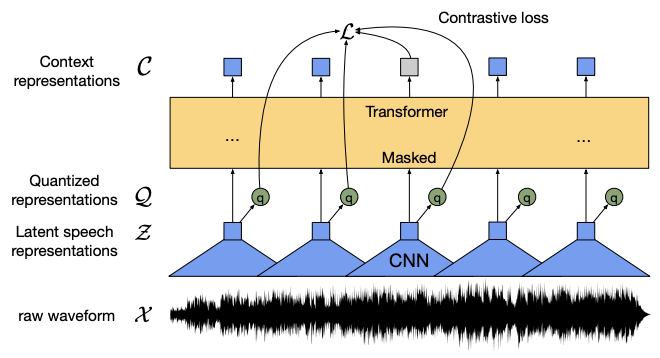

In [16]:
# Initilize the model & tokenizer for wav2vec2 
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:423: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
audio, sr = librosa.load('/content/pre.wav',sr = sr)

# tokenize the audio data so that it can be used in the model
input_values = tokenizer(audio, return_tensors = "pt").input_values

# store non-normalized predictions based on the logit function applied to the input values
logits = model(input_values).logits

# calculate the predicted transcription of the audio file.
prediction = torch.argmax(logits, dim = -1)

results = tokenizer.batch_decode(prediction)[0]
print(results)


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


EN MYBE THAT'S THE WAY YOU DO KINDES SOPSTO TE COWLOGIMEA INDIFFERENT CLADES AND THEN MAYBE YOU HAVE MORE PREDICTI COWER THERE A RATHERN DOING THE WHOLE THING NO COPRANE KOGOKKONE THINKING ONE THE LINE BUT I CUWOF ALWORTY CONCITERING COOD PEOPLE NONDER UNDER PRINGERING OUT PORTAL WH


POST PROCESSING

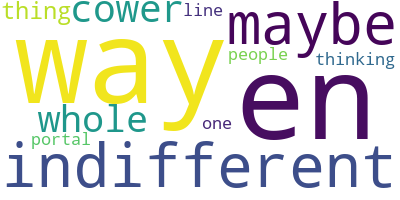

In [40]:
dictionary = enchant.Dict("en_US")

# Convert results to lower case so they can be checked
for i in range(len(results)):
    results[i] = results[i].lower()

# Remove Non-english words from list and make a wordle from that collection
filtered_results = []
for word in results:
  if dictionary.check(word):
    filtered_results.append(word)
# Prep filtered results for wordle creation by changing format to string seperated by spaces
final = ''
for x in filtered_results:
  final += " " + x

# Create the word cloud and display it
create_word_cloud(final)
IPython.display.Image('/content/wordCloud.png')